## Installations



In [0]:
!pip3 install librosa==0.7
!pip install adversarial-robustness-toolbox
!pip install matplotlib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports and loading pre-processed dataset from disk


In [4]:
import pandas as pd
import numpy as np
import glob
import scipy
import matplotlib.pyplot as plt
import re
import os
from scipy.io import wavfile
import librosa
import IPython.display as ipd
import librosa.display
%matplotlib inline
import keras
import art
import random

from art.attacks.evasion import FastGradientMethod 
from art.metrics import empirical_robustness
from art.metrics import clever_u
from art.attacks.evasion import SaliencyMapMethod
from art.attacks.evasion import DeepFool
from art.utils import to_categorical as one_hot
from art.metrics import loss_sensitivity as loss_sens
from art.utils import second_most_likely_class as snd_likely
from art.defences.transformer import DefensiveDistillation
from art.defences.trainer import AdversarialTrainer as AdvTrainer
import matplotlib.pyplot as plt



Using TensorFlow backend.


## Standardizing the dataset, and picking a smaller subset with labels not "unknown"

In [5]:
#train_df = pd.read_pickle('./drive/My Drive/adver/train_df_dec10.pkl')
#val_df = pd.read_pickle('./drive/My Drive/adver/valid_df_dec10.pkl')
x_train = np.load('./drive/My Drive/adver/x_train_vec_dec10.npy')
y_train = np.load('./drive/My Drive/adver/y_train_vec_dec10.npy')
x_test = np.load('./drive/My Drive/adver/x_test_vec_dec10.npy')
y_test = np.load('./drive/My Drive/adver/y_test_vec_dec10.npy')
print(x_train[0].shape)

def standardize(x , x_t):
  mean = np.mean(x , axis = 0 , keepdims = True)
  sd = np.std(x , axis = 0 , keepdims = True)
  return (x - mean)/sd , (x_t - mean)/sd

#x_train , x_test = standardize(x_train , x_test)


mask = (y_test != 10)
filtered_x_test = x_test[mask]
filtered_y_test = y_test[mask]
print(filtered_x_test.shape)

mask = (y_train != 10)
filtered_x_train = x_train[mask]
filtered_y_train = y_train[mask]
print(filtered_x_train.shape)

(128, 32, 1)
(2577, 128, 32, 1)
(49410, 128, 32, 1)


## MISC functions


In [7]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go unknown silence'.split(' ')
print(POSSIBLE_LABELS)
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}

#getting class weights for NN initialization
def get_class_weight(y):
  ind, counts = np.unique(y, return_counts=True)
  class_weight = {i: count for i, count in zip(ind, counts)}
  class_weight = {ind: len(y)/val for ind, val in class_weight.items()}
  return class_weight

num_labels = 12

# clone a model
def model_cloner(src):
  model_copy= init_empty_model()
  model_copy.set_weights(src.get_weights())
  return model_copy

from sklearn.metrics import accuracy_score

# evaluate a wrapped a.r.t classifier
def eval(cls , x , y):
  _p = cls.predict(x)
  y_pred = np.argmax(_p , axis = 1)
  return accuracy_score(y_pred , y)

# sample "sz" elements from np array
def random_samplenp(x , y , sz):
  perm = np.random.permutation(len(x))
  xp = x[perm]
  yp = y[perm]
  mn = min(sz , len(x))
  return xp[:mn] , yp[:mn]

# get average confidence of the adversarial generated samples
def get_avg_conf(orig_y , adv_y):
  ret = 0
  indiv = []
  for i in range(len(orig_y)):
    idx_1 = orig_y[i].argmax()
    idx_2 = adv_y[i].argmax()
    if idx_1 == idx_2:
      indiv.append(0)
      continue
    ret += adv_y[i][idx_2]
    indiv.append(adv_y[i][idx_2])
  ret /= len(orig_y)
  return (ret,indiv)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']


## Model Definition

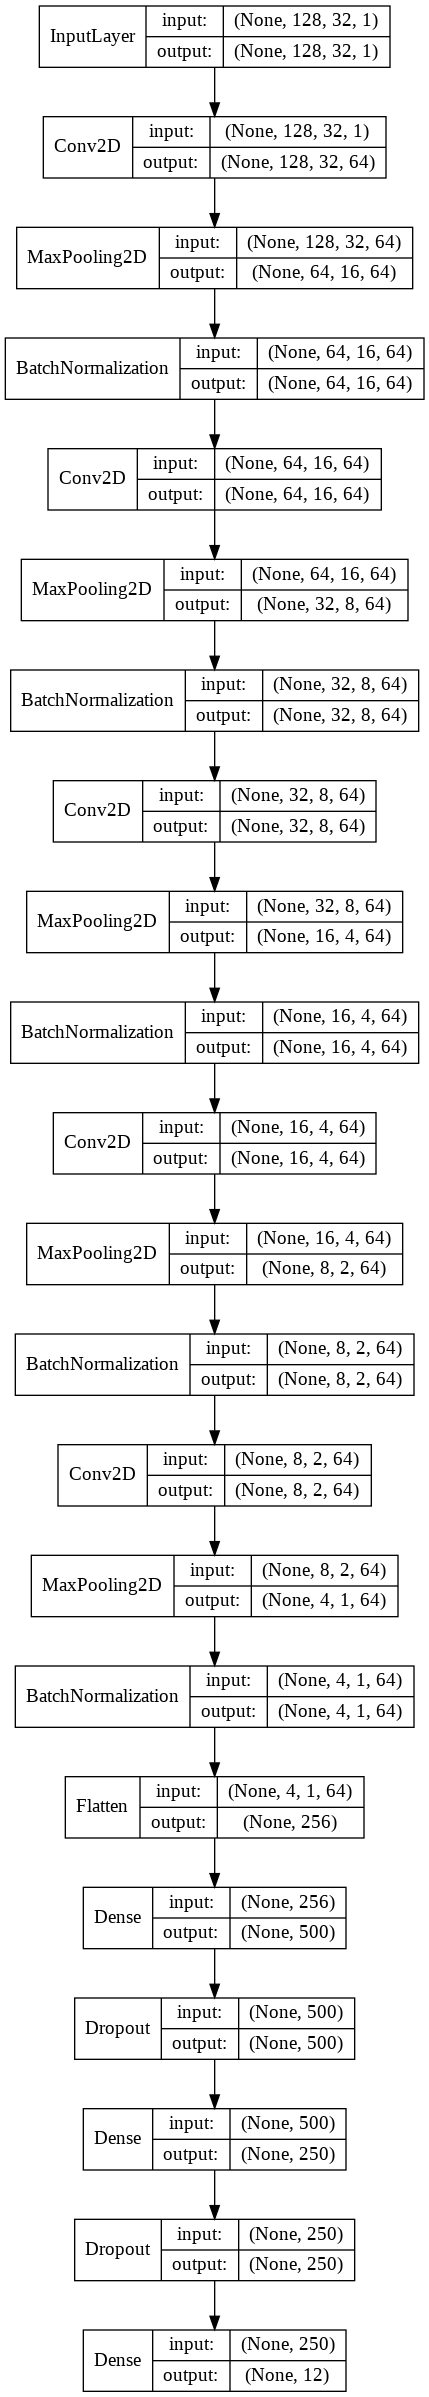

In [8]:

import keras

def init_empty_model():
  model = keras.Sequential([
      keras.layers.InputLayer(input_shape=(128,32,1)),
      keras.layers.Conv2D(64, kernel_size=(20,8), strides=1, padding='same', activation='relu'),
      keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(64, kernel_size=(10,4),
      padding='same', activation='relu'),
      keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(64, kernel_size=(5,2), padding='same', activation='relu'),
      keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(64, kernel_size=(2,2), padding='same', activation='relu'),
      keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(64, kernel_size=(2,1), padding='same', activation='relu'),
      keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Flatten(),
      keras.layers.Dense(500, activation="relu"),
      keras.layers.Dropout(.5),
      keras.layers.Dense(250, activation="relu"),
      keras.layers.Dropout(.4),
      keras.layers.Dense(num_labels, activation="softmax")
  ])

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer='nadam',
                metrics=['accuracy'])
  return model

keras.utils.plot_model(init_empty_model(), show_shapes=True , show_layer_names = False)
#model.load_weights('./drive/My Drive/adver/finalmodel.h5')

## Defenseless Model

In [9]:
raw_model = init_empty_model()
raw_model.load_weights('./drive/My Drive/adver/trained.h5')
raw_model_cls = art.classifiers.KerasClassifier(model=raw_model, clip_values=(-10,10),  use_logits=False)
print("Accuracy on test: ",eval(raw_model_cls , x_test , y_test))

Accuracy on test:  0.9560164754339512


## Generation of adversarials with checkpoints

In [0]:
def safe_generation(cls , atk , X , Y , name , resume = False):
  df_batch = 100
  batches = (len(X) + df_batch - 1)//df_batch
  print(batches)
  if resume == True:
    checkpoint = np.load("./drive/My Drive/adver/checkpoint.npy")
    st = len(checkpoint) // df_batch
    print(len(checkpoint) , st)
  
  for i in range(st,batches):
    l = i * df_batch
    r = min( (i + 1) * df_batch , len(X))
    sx , sy = X[l:r] , Y[l:r]
    
    advs = atk.generate(sx , sy)
    if i == 0:
      checkpoint = advs
    else:
      checkpoint = np.vstack((checkpoint , advs))

    print(i , checkpoint.shape , eval(cls , advs , sy) , ": done")
    np.save("./drive/My Drive/adver/checkpoint.npy",checkpoint)
  np.save("./drive/My Drive/adver/" + name + "x" + ".npy" , checkpoint)



## FGSM Benchmark

In [0]:

def fgsm_bench(cls , samplex , sampley):

  fgsm_eps = [0.01 , 0.05 , 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 1 , 1.25 , 1.5 , 1.75 , 2 , 2.5 , 3]
  fgsm_accs = []

  for e in fgsm_eps:
    fgsm = FastGradientMethod(cls , eps = e , minimal = True)
    advs = fgsm.generate(samplex)
    acc = eval(cls , advs , sampley)
    fgsm_accs.append(acc)
  return fgsm_eps , fgsm_accs


## DeepFool Benchmark

In [0]:
def deepfool_bench(cls , samplex , sampley):

  dfool_iters = [1,2,3,4,5,6,7,8,9,10,12,15]
  dfool_accs = []
  dfool_avg_delta = []
  dfool_changed = []

  for e in dfool_iters:
    deepfool = DeepFool(cls , max_iter = e , nb_grads = 12)
    advs = deepfool.generate(samplex)
    
    acc = eval(cls , advs , sampley)
    
    delta = (np.absolute(advs - samplex)**2).sum() / len(samplex)
    dfool_avg_delta.append(delta)

    dfool_changed.append( np.count_nonzero( abs(advs - samplex) > 1e-5 ) / len(samplex) )

    print(acc)
  return dfool_iters , dfool_accs , dfool_avg_delta , dfool_changed

## JSMA Benchmark

In [0]:

def jsma_bench(cls , samplex , sampley):

  jsma_eps = [0.1,0.3,0.5,0.8,1,1.2,1.4,1.6,1.8,2,2.3,2.5,2.8,3]
  jsma_avg_delta = []
  jsma_confs = []
  jsma_changed = []
  jsma_tar = snd_likely(samplex , cls)
  for e in jsma_eps:
    jsma = SaliencyMapMethod(cls , theta = e , gamma = 1.0)
    advs = jsma.generate(samplex , jsma_tar)

    delta = (np.absolute(advs - samplex)**2).sum() / len(samplex)
    jsma_avg_delta.append(delta)

    jsma_changed.append( np.count_nonzero( abs(advs - samplex) > 1e-5 ) / len(samplex) )

    conf = get_avg_conf(cls.predict(samplex) , cls.predict(advs))
    jsma_confs.append(conf)

  return jsma_eps , jsma_confs ,  jsma_avg_delta , jsma_changed


In [0]:
samplex , sampley = random_samplenp(filtered_x_test , filtered_y_test , 100)
fgsm_bench(raw_model_cls , samplex , sampley)

# Adversarial Train

In [0]:
#using ibm a.r.t library
t_model = init_empty_model()
t_cls = art.classifiers.KerasClassifier(model= t_model ,  use_logits=False, clip_values=(-10,10))
fgsm_atk = FastGradientMethod(t_cls , eps = 1)
fgsm_trained_cls = AdvTrainer(classifier=t_cls , attacks=fgsm_atk , ratio = 0.5)
fgsm_trained_cls.fit(x_train , y_train , batch_size= 256 , nb_epochs=20)


In [0]:
train_fgsmres = fgsm_bench(fgsm_trained_cls , samplex , sampley)
train_jsma = jsma_bench(fgsm_trained_cls , samplex , sampley)
train_dfool = deepfool_bench(fgsm_trained_cls , samplex , sampley)

## Randomized Gaussian Noise

In [0]:
from art.defences.preprocessor import GaussianAugmentation as Gauss
g_model = init_empty_model()
g_cls = art.classifiers.KerasClassifier(model= g_model ,  use_logits=False, clip_values=(-10,10))
gauss = Gauss(sigma=1.0, augmentation=True, ratio=1.0, clip_values=(-10,10))
gauss_x_train , gauss_y_train = gauss(x_train , y_train)
g_cls.fit(gauss_x_train , gauss_y_train , batch_size= 256 , nb_epochs=20)


## Local sensitivity loss measurent

In [0]:
def LSL(cls , x , y , sz):
  xx , yy = random_samplenp(x , y , min(sz , len(x)))
  return loss_sens(cls , x , y)


## Generation of adversarial examples

### Defining attacks


In [0]:
raw_model_cls = art.classifiers.KerasClassifier(model=raw_model, clip_values=(-10,10),  use_logits=False)
fgsm_atk = FastGradientMethod(raw_model_cls , eps = 2 , minimal = True)
deepfool_atk = DeepFool(raw_model_cls , max_iter = 50 , nb_grads = 12)
jsma_atk = SaliencyMapMethod(raw_model_cls , theta = 1.0)

### Generation of adversarial examples for other experiments

In [0]:
safe_generation(cls , fgsm_atk , x_train , y_train , "fgsm")
safe_generation(cls , deepfool_atk , x_train , y_train , "deepfool")
safe_generation(cls , jsma_atk , x-train , y_train , "jsma")

In [0]:
fgsm_x = np.load("./drive/My Drive/adver/fgsmx.npy")
fgsm_y = np.load("./drive/My Drive/adver/fgsmy.npy")
fgsm_aug_x = np.concatenate((fgsm_x , x_train) , axis = 0)
fgsm_aug_y = np.concatenate((fgsm_y , y_train) , axis = 0)
fgsm_aug_x , fgsm_aug_y = random_samplenp(fgsm_aug_x , fgsm_aug_y , len(fgsm_aug_x))
print(fgsm_aug_x.shape , fgsm_aug_y.shape)

In [0]:
jsma_x = np.load("./drive/My Drive/adver/jsmax.npy")
jsma_y = np.load("./drive/My Drive/adver/jsmay.npy")
jsma_aug_x = np.concatenate((jsma_x , x_train) , axis = 0)
jsma_aug_y = np.concatenate((jsma_y , y_train) , axis = 0)
jsma_aug_x , jsma_aug_y = random_samplenp(jsma_aug_x , jsma_aug_y , len(jsma_aug_x))
print(jsma_aug_x.shape , jsma_aug_y.shape)

